# Notes on Simpson's Paradox

Probability is [famously counterintuitive](https://www.johndcook.com/blog/2014/01/21/probability-is-subtle/), and replete with paradoxes. In this post, I'll work an example of one paradox using mathematical python libraries.

In [Simpson's paradox](https://plato.stanford.edu/entries/paradox-simpson/) a data set can appear to indicate that a drug does not work in aggregate, but does work for all subgroups which comprise the population (e.g. segmenting by age, sex or ethnicity). Let's find some examples of Simpson's paradox using the [z3 solver](https://ericpony.github.io/z3py-tutorial/guide-examples.htm):

In [1]:
from typing import *
import itertools as it
import z3
import pandas as pd

def find_simpson_paradox(group_to_size: Dict[str, Tuple[int, int]]) -> Optional[pd.DataFrame]:
    s = z3.Solver()
    all_treatment_vars, all_control_vars = [], []
    for group, (treatment_size, control_size) in group_to_size.items():
        treatment_vars = [z3.Real(f"{group}_treatment_{i}") for i in range(treatment_size)]
        all_treatment_vars.extend(treatment_vars)
        control_vars = [z3.Real(f"{group}_control_{i}") for i in range(control_size)]
        all_control_vars.extend(control_vars)
        # The treatment must work on a larger proportion of the treatment than controls in each
        # subgroup.
        s.add(sum(treatment_vars) / len(treatment_vars) > sum(control_vars) / len(control_vars))
    SUCCESS = 1
    FAILURE = 0
    for var in all_treatment_vars + all_control_vars:
        s.add(z3.Or(var == SUCCESS, var == FAILURE))
    # The treatment must work on a smaller proportion of the treatment than controls in aggregate.
    s.add(sum(all_treatment_vars) / len(all_treatment_vars) < sum(all_control_vars) / len(all_control_vars))
    if s.check() == z3.unsat:
        return None
    else:
        z3_model = s.model()
        model = {str(var): z3_model[var] for var in all_treatment_vars + all_control_vars}
        data = []
        for var, value in model.items():
            subgroup, treatment, idx = var.split('_')
            data.append({"Subgroup": subgroup, "Treatment": treatment, "Outcome": int(value.as_long())})
        return pd.DataFrame(data)

Here we have a treatment which yields a binary result (e.g. the patient survived), and we're looking for an assignment of data such that there's a larger proportion of success outcomes in each of the subgroups than in the aggregate. Now we can find the smallest such example:

In [2]:
for treatment1, control1, treatment2, control2 in it.product(range(1, 4), range(1, 4), range(1, 4), range(1, 4)):
    assert find_simpson_paradox({"child": (treatment1, control1), "adult": (treatment2, control2)}) is None
df = find_simpson_paradox({"child": (4, 1), "adult": (1, 4)})

In [3]:
# hide_input
df

,Subgroup,Treatment,Outcome
0,child,treatment,0
1,child,treatment,0
2,child,treatment,0
3,child,treatment,1
4,adult,treatment,1
5,child,control,0
6,adult,control,1
7,adult,control,1
8,adult,control,0
9,adult,control,1


In [4]:
# hide_input
from IPython.display import Markdown, display

def one_paragraph(s):
    return s.replace('    ', '').replace('\n', ' ')

from IPython.display import display,HTML

def multi_column_df_display(list_dfs, cols=3):
    # https://stackoverflow.com/a/42866792/303931
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)

    cells = [ html_cell.format(content=df.to_html()) for df in list_dfs ]
    cells += (cols - (len(list_dfs)%cols)) * [html_cell.format(content="")] # pad
    rows = [ html_row.format(content="".join(cells[i:i+cols])) for i in range(0,len(cells),cols)]
    display(HTML(html_table.format(content="".join(rows))))

df1 = df.groupby(['Subgroup', 'Treatment']).mean().rename(columns={'Outcome': "Proportion Improved"})
df1['Total Improved'] = df.groupby(['Subgroup', 'Treatment']).sum()['Outcome']
df1['Sample Size'] = df.groupby(['Subgroup', 'Treatment']).count()['Outcome']
multi_column_df_display([
    df.groupby('Treatment').mean(),
    df.groupby('Subgroup').mean(),
    df1,
])


OK, so what's going on here? Basically in the adult subgroup, the treatment group was very small (a single data point), and 100% of them got better. Similarly the child control group was a single data point, and they did poorly (0%) while 3/4 of the child treatment group did poorly (so 25% > 0%).

## A paradox?

At this level of concreteness, Simpson's paradox seems very straightforward. Nobody would design an experiment this way and these are very small numbers. (Though you could, of course, multiply them by 100 or 1,000 and the numbers wouldn't sound small anymore.) So where is the "paradox" coming from?

A paradox is something where you have a compelling argument or intuition for some claim, but _also_ an equally compelling argument against the claim. There are examples (depending on the causal process you assume generated the data) where, the "right" average to use can be from some or all of the subgroups, or the aggregate data. So that's part of the paradox: the problem is underspecified and cannot always be sorted out from data alone.

However, we have an intuition that if a drug works for children _and_ a drug works for adults, then it must work for everyone. Maybe that intuition assumes that things are roughly balanced between the populations, obviously false in this example.

Let's consider what happens when the groups are _exactly_ balanced. Suppose the subgroups and treatment and control groups all have exactly the same size. Let $t_0, c_0, t_1, c_1$ denote the number of successes in the treatment ($t_i$) and control ($c_i$) groups of the 0 and 1 subgroups. Assume also that each group is of size $g$. Then for Simpson's paradox, we'd have:
\begin{align}
 \frac{t_0}{g} &> \frac{c_0}{g} \\
 \frac{t_1}{g} &> \frac{c_1}{g} \\
 \frac{t_0 + t_1}{2g} &< \frac{c_0 + c_1}{2g} \\
\end{align}
Clearing the denominators in on each side of the inequalities yields:
\begin{align}
 t_0 &> c_0 \\
 t_1 &> c_1 \\
 t_0 + t_1 &< c_0 + c_1 \\
\end{align}

Adding the first two inequalities together, we also get that $t_0 + t_1 > c_0 + c_1$, which is a contradiction. Therefore we need at least _some_ imbalance to attain an instance of Simpson's paradox.

## Causality

These notes were inspired by some of Judea Pearl's writing, especially [Causality](https://amzn.to/2ZBHC6r), which we're currently (very slowly) working through in my technical book club. For Pearl, Simpson's paradox is fundamentally about causality, since it can often be "solved" by figuring out what's causing what inside a dataset.

As a hypothetical example, you could find in a data set that the rate of death is much higher among people using a particular blood pressure medication. But the drug lowers the death rate among people with high and low cholesterol. The solution in this case is to posit some extra causal factors (e.g. "metabolic syndrome") that causes high blood pressure, high cholesterol and increased death. Graphically:


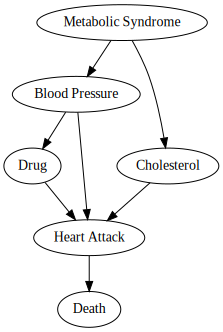

In [16]:
# hide_input
import pygraphviz as pgv
from IPython.display import Image, SVG, display
import networkx as nx

def draw(graph):
    svg = nx.nx_agraph.to_agraph(graph).draw(prog='dot',format='svg')
    display(SVG(svg))

    
import networkx as nx
G = nx.DiGraph()
G.add_edge('Blood Pressure', 'Drug')
G.add_edge('Blood Pressure', 'Heart Attack')
G.add_edge('Cholesterol', 'Heart Attack')
G.add_edge('Metabolic Syndrome', 'Blood Pressure')
G.add_edge('Metabolic Syndrome', 'Cholesterol')
G.add_edge('Drug', 'Heart Attack')
G.add_edge('Heart Attack', 'Death')

draw(G)

Then the data might not be so paradoxical. High blood pressure causes heart attacks, which blood pressure medication helps to prevent. Since people with high blood pressure are both much more likely to get the drug as treatment _and_ more likely to die, the first result makes sense: the death rate is higher among people who are taking the drug because they're sick. 

## Interesting question
One interesting question we could ask is: given a particular level of difference between the sample means $\epsilon$, how big of an imbalance in the group sizes do we need to attain that?